In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import csv
import math
from tensorflow import keras
from tensorflow.keras import layers


import cv2
import numpy as np
from keras import Model
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import MaxPooling2D, Conv2D, Reshape, Dense, Flatten
import tensorflow as tf
from keras.datasets import cifar10
import sys
import matplotlib.pyplot as plt
print(tf.__version__)
#print(tf.keras.__version__)

#testing the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.15.0
Found GPU at: /device:GPU:0


### Import Dataset

In [2]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print ('Training data seize:', train_images.shape, 'Test data size', test_images.shape)

# Normalize pixel values between -1 and 1 [you can normalize between 0 and 1 also]
train_images = train_images / 127.5 - 1
test_images = test_images / 127.5 - 1

Training data seize: (50000, 32, 32, 3) Test data size (10000, 32, 32, 3)


### Visualize dataset

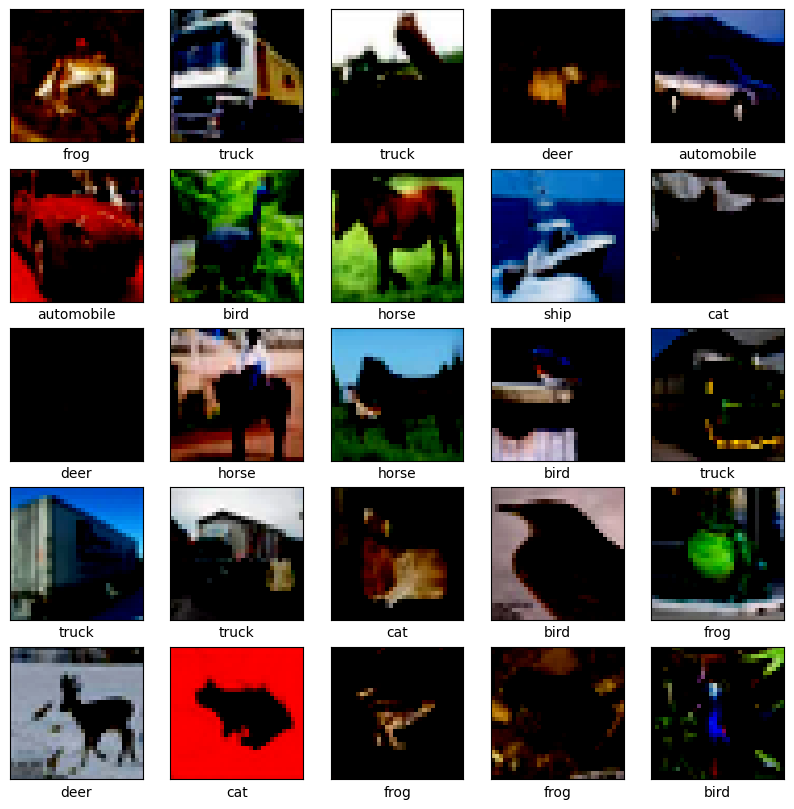

In [3]:
%matplotlib inline
#Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

### Resize images for use with MobileNetV2

In [4]:
# Upsize all training and testing images to 96x96 for use with mobile net
minSize = 96 #minimum size required for mobileNetV2

# You may use cv2 package. Look for function:
import cv2
#"cv2.resize(<originalImage>, dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)"
# resize train image: You can first initialize a numpy array resized_train_images to store all the resized training images
resized_train_images = np.zeros((10000, minSize, minSize, 3), dtype=np.float32)

# <Write code for resizing>
# go through the first 10k train_images to resize
for i in range(10000):
    resized_train_images[i] = cv2.resize(train_images[i], dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)

#resize train_labels
resized_train_labels = train_labels[:10000]

# resize test image: You can first initialize a numpy array resized_test_images to store all the resized test images
resized_test_images = np.zeros((10000, minSize, minSize, 3), dtype=np.float32)
# <Write code for resizing>
# go through the first 10k test_images to resize
for i in range(len(test_images)):
    resized_test_images[i] = cv2.resize(test_images[i], dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)


sys.getsizeof(resized_train_images)

1105920160

### Download MobileNetV2 model



In [5]:
#<Write code for downloading MobileNetV2>
from keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = tf.keras.applications.MobileNetV2(input_shape=(minSize, minSize, 3),
                                               include_top=False,
                                               weights='imagenet')


### Add custom layers at the end of downloaded model

In [6]:
x = base_model.output

#x = layers.Conv2D(50, kernel_size=(3, 3), strides=(1, 1), activation='tanh')(x)
x = layers.Dense(140, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(10, activation='softmax')(x)
inputs = base_model.input

# Create a new model with the base_model's input and your custom output layer
model = Model(inputs=inputs, outputs=output_layer)

# model.summary()


### Add loss function, compile and train the model, and check accuracy on test data

In [7]:
#<Write code>
#compile with loss function
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
epochs = 25
batch_size = 32

from keras.callbacks import EarlyStopping
# threshold 
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = model.fit(resized_train_images, resized_train_labels, batch_size = batch_size, epochs=epochs,callbacks=[early_stopping])


Epoch 1/25
313/313 [==============================] - 45s 45ms/step - loss: 0.9192 - accuracy: 0.7091
Epoch 2/25
313/313 [==============================] - 13s 41ms/step - loss: 0.6114 - accuracy: 0.8060
Epoch 3/25
313/313 [==============================] - 12s 40ms/step - loss: 0.4924 - accuracy: 0.8365
Epoch 4/25
313/313 [==============================] - 13s 43ms/step - loss: 0.4159 - accuracy: 0.8666
Epoch 5/25
313/313 [==============================] - 13s 41ms/step - loss: 0.3565 - accuracy: 0.8832
Epoch 6/25
313/313 [==============================] - 13s 40ms/step - loss: 0.3081 - accuracy: 0.8993
Epoch 7/25
313/313 [==============================] - 12s 40ms/step - loss: 0.2774 - accuracy: 0.9089
Epoch 8/25
313/313 [==============================] - 12s 40ms/step - loss: 0.2452 - accuracy: 0.9182
Epoch 9/25
313/313 [==============================] - 12s 40ms/step - loss: 0.2327 - accuracy: 0.9225
Epoch 10/25
313/313 [==============================] - 13s 40ms/step - loss: 0.222

In [9]:
test_loss, test_acc = model.evaluate(resized_test_images, test_labels)

313/313 [==============================] - 6s 14ms/step - loss: 1.5953 - accuracy: 0.7313


### Extra code for producing different plots

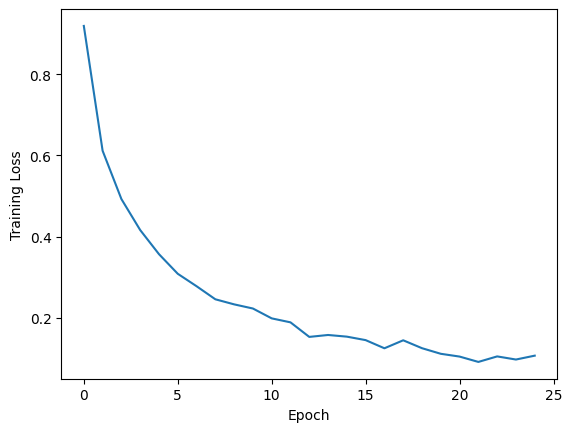

In [10]:
### write your code here to plot training loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()